In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import os
import joblib
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
from collections import namedtuple
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader, random_split
import copy
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from mlp import *
from data import *
from ae import *
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import shap

In [ ]:
dataset_path = download_grabmyo_dataset()

Using dataset from Google Drive: /content/drive/MyDrive/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0.zip

Extracting files...
Dataset extracted to: grabmyo_data
✓ Extraction complete! Marker file created.


In [ ]:
# Configuration
DATA_ROOT = 'grabmyo_data'
GESTURE = 1
INCLUDE_CHANNELS = [9,10,11,12,13,14,15,16,18,19,20,21,22,23]
# INCLUDE_CHANNELS = [9,10,11,15]
FS = 2000
RANDOM_SEED = 42

set_random_seeds(RANDOM_SEED)
# Load raw data
metadata, signals, channel_names = load_emg_data(
    data_root=DATA_ROOT,
    gesture=GESTURE,
    include_indices=INCLUDE_CHANNELS
)

print(f"\nSignal shape: {signals.shape}")
print(f"Number of trials: {len(metadata)}")
print(f"Number of subjects: {metadata['subject'].nunique()}")
print(f"Channels: {len(channel_names)}")

In [ ]:
# Configuration
DATA_ROOT = 'grabmyo_data'
GESTURE = 1
INCLUDE_CHANNELS = [9,10,11,12,13,14,15,16,18,19,20,21,22,23]
# INCLUDE_CHANNELS = [9,10,11,15]
FS = 2000
RANDOM_SEED = 42

set_random_seeds(RANDOM_SEED)
# Load raw data
metadata, signals, channel_names = load_emg_data(
    data_root=DATA_ROOT,
    gesture=GESTURE,
    include_indices=INCLUDE_CHANNELS
)

print(f"\nSignal shape: {signals.shape}")
print(f"Number of trials: {len(metadata)}")
print(f"Number of subjects: {metadata['subject'].nunique()}")
print(f"Channels: {len(channel_names)}")


# Load raw data
metadata, signals, channel_names = load_emg_data(
    data_root=DATA_ROOT,
    gesture=GESTURE,
    include_indices=INCLUDE_CHANNELS
)

print(f"\nSignal shape: {signals.shape}")
print(f"Number of trials: {len(metadata)}")
print(f"Number of subjects: {metadata['subject'].nunique()}")
print(f"Channels: {len(channel_names)}")

Loaded 903 trials for gesture 1
Shape: (903, 10240, 14)
Subjects: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43)]

Signal shape: (903, 10240, 14)
Number of trials: 903
Number of subjects: 43
Channels: 14


In [ ]:
signals_clean = clean_all_trials(signals, fs=FS)

Cleaning 903 trials...
  Cleaned 50/903
  Cleaned 100/903
  Cleaned 150/903
  Cleaned 200/903
  Cleaned 250/903
  Cleaned 300/903
  Cleaned 350/903
  Cleaned 400/903
  Cleaned 450/903
  Cleaned 500/903
  Cleaned 550/903
  Cleaned 600/903
  Cleaned 650/903
  Cleaned 700/903
  Cleaned 750/903
  Cleaned 800/903
  Cleaned 850/903
  Cleaned 900/903


In [ ]:
# Extract discrete features only
X_discrete = []

print("Extracting discrete features...")
for i in range(signals_clean.shape[0]):
    features = extract_all_discrete_features(signals_clean[i], fs=FS)
    X_discrete.append(features)

    if (i + 1) % 50 == 0:
        print(f"  {i+1}/{signals_clean.shape[0]}")

X_discrete = np.array(X_discrete)

print(f"\nFeature matrix shape: {X_discrete.shape}")

Extracting discrete features...
  50/903
  100/903
  150/903
  200/903
  250/903
  300/903
  350/903
  400/903
  450/903
  500/903
  550/903
  600/903
  650/903
  700/903
  750/903
  800/903
  850/903
  900/903

Feature matrix shape: (903, 112)


In [ ]:
def get_ae_features_batched(signals, ae_model, ts_scaler, batch_size=256, device='cuda'):
    """
    Extracts features in batches to prevent CUDA Out of Memory errors.
    """
    n_trials, length, channels = signals.shape

    # Scale Data
    signals_flat = signals.reshape(-1, channels)
    signals_scaled_flat = ts_scaler.transform(signals_flat) 
    signals_scaled = signals_scaled_flat.reshape(n_trials, length, channels)

    # Transpose to (N, Ch, L) and then Reshape to (N*Ch, 1, L)
    signals_scaled = np.transpose(signals_scaled, (0, 2, 1))
    signals_scaled = signals_scaled.reshape(-1, 1, length)

    # Create DataLoader for inference
    dataset = TensorDataset(torch.tensor(signals_scaled, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    ae_model.eval()
    all_latents = []

    print(f"Extracting AE features in batches...")
    with torch.no_grad():
        for batch in loader:
            x_batch = batch[0].to(device)
            # Get Latent (Batch_Size, Latent_Dim)
            z = ae_model.get_latent_features(x_batch)
            all_latents.append(z.cpu().numpy())

    # Concatenate all batches
    latent_all = np.concatenate(all_latents, axis=0)

    # Reshape back to (N_Trials, Channels * Latent_Dim)
    latent_per_trial = latent_all.reshape(n_trials, -1)
    return latent_per_trial

In [ ]:

MAIN_SUBJECT = 37

metadata['y'] = np.where(metadata['subject'] == MAIN_SUBJECT, 1, 0)
y = metadata['y'].values

sessions = metadata['session'].values
train_mask = (
    (metadata['subject'] <= 35) |  
    ((metadata['subject'] == MAIN_SUBJECT) & (metadata['session'].isin([1, 2])))
)
test_mask = (
    ((metadata['subject'] == MAIN_SUBJECT) & (metadata['session'] == 3)) |
    (metadata['subject'] >= 39)
)

train_signals = signals_clean[train_mask, : , :]
X_train = X_discrete[train_mask]
y_train = y[train_mask]

test_signals = signals_clean[test_mask, :, :]
X_test = X_discrete[test_mask]
y_test = y[test_mask]

print(f"\nTrain: {X_train.shape[0]} samples")
print(f"  Unique subjects: {len(np.unique(y_train))}")
print(f"  Sessions: {np.unique(sessions[train_mask])}")

print(f"\nTest: {X_test.shape[0]} samples")
print(f"  Unique subjects: {len(np.unique(y_test))}")
print(f"  Sessions: {np.unique(sessions[test_mask])}")

print("\nExtracting AE latent features...")
AE_MODEL_PATH = "emg_clean_split_best.pth"
# Load trained AE model
device = "cuda"
ae_model = AE.load_model(AE_MODEL_PATH, device=device)


# 1. Load the original full scaler
full_scaler = joblib.load('ts_scaler.pkl')

# 2. Hack the scaler
subset_scaler = copy.deepcopy(full_scaler)
selected_indices = [9,10,11,12,13,14,15,16,18,19,20,21,22,23]
subset_scaler.mean_ = full_scaler.mean_[selected_indices]
subset_scaler.scale_ = full_scaler.scale_[selected_indices]
subset_scaler.var_ = full_scaler.var_[selected_indices]
subset_scaler.n_features_in_ = len(selected_indices)

# 3. Extract Features
X_ae = get_ae_features_batched(
    signals_clean,
    ae_model,
    subset_scaler,
    batch_size=512,
    device=device
)

# 4. Concatenate & Scale
X_combined = np.concatenate([X_discrete, X_ae], axis=1)
final_scaler = StandardScaler()
X_final = final_scaler.fit_transform(X_combined)
print(f"Final Input Shape: {X_final.shape}")

# --- 2. DATA SPLITTING & SMOTE INTEGRATION ---

# --- A. Pre-training Data (Multiclass: Subjects 1-35) ---
mask_pretrain = metadata['subject'] <= 35
X_pre = X_final[mask_pretrain]
y_pre = metadata[mask_pretrain]['subject'].values - 1

# --- B. Fine-tuning Data (Binary: Subj 36 vs Rest) ---
mask_target_train = (metadata['subject'] == MAIN_SUBJECT) & (metadata['session'].isin([1, 2]))
mask_impostor_train = (metadata['subject'] <= 35)

X_ft_pos = X_final[mask_target_train]
X_ft_neg = X_final[mask_impostor_train]

# create raw arrays
X_ft_raw = np.concatenate([X_ft_pos, X_ft_neg])
y_ft_raw = np.concatenate([np.ones(len(X_ft_pos)), np.zeros(len(X_ft_neg))])


# ==========================================
print(f"\n--- Applying SMOTE to Fine-Tuning Data ---")
print(f"Before SMOTE: Genuine={sum(y_ft_raw==1)}, Impostor={sum(y_ft_raw==0)}")


smote = SMOTE(sampling_strategy=0.4, random_state=42, k_neighbors=2)
X_ft_aug, y_ft_aug = smote.fit_resample(X_ft_raw, y_ft_raw)

print(f"After SMOTE:  Genuine={sum(y_ft_aug==1)}, Impostor={sum(y_ft_aug==0)}")
# ==========================================

X_test = X_final[test_mask]
y_test = np.where(metadata[test_mask]['subject'] == MAIN_SUBJECT, 1, 0)


# --- 3. CREATE DATALOADERS ---
batch_size = 15

# Pre-train loader (Unchanged)
train_loader_pre = DataLoader(
    TensorDataset(torch.tensor(X_pre).float(), torch.tensor(y_pre).long()),
    batch_size=batch_size,
    shuffle=True
)

# Fine-tune loader (Uses AUGMENTED data)
train_loader_ft = DataLoader(
    TensorDataset(torch.tensor(X_ft_aug).float(), torch.tensor(y_ft_aug).float()),
    batch_size=batch_size,
    shuffle=True
)


mlp = MLP(input_dim=X_final.shape[1], num_classes=35, device=device)

# PHASE 1: Pre-train on population
mlp.train_pretraining(train_loader_pre, epochs=50)

# PHASE 2: Adapt to Target
mlp.prepare_for_finetuning()

# Calculate New Positive Weight
num_neg = sum(y_ft_aug == 0)
num_pos = sum(y_ft_aug == 1)
pos_weight = num_neg / num_pos

print(f"Recalculated Positive Weight after SMOTE: {pos_weight:.2f}")

mlp.train_finetuning(
    train_loader_ft,
    pos_weight=pos_weight,
    epochs=30,
    head_lr=0.1,
    body_lr=1e-6  
)

# --- 5. EVALUATION ---

test_tensor = torch.tensor(X_test).float().to(device)
y_scores = mlp.predict_score(test_tensor).cpu().numpy().flatten()




Train: 749 samples
  Unique subjects: 2
  Sessions: [1 2 3]

Test: 112 samples
  Unique subjects: 2
  Sessions: [1 2 3]

Extracting AE latent features...
Extracting AE features in batches...
Final Input Shape: (903, 392)

--- Applying SMOTE to Fine-Tuning Data ---
Before SMOTE: Genuine=14, Impostor=735
After SMOTE:  Genuine=294, Impostor=735

--- Starting Pre-training on cuda ---
Epoch 10/50 | Loss: 1.6415 | Acc: 56.33%
Epoch 20/50 | Loss: 0.8651 | Acc: 77.41%
Epoch 30/50 | Loss: 0.5875 | Acc: 84.90%
Epoch 40/50 | Loss: 0.4258 | Acc: 87.76%
Epoch 50/50 | Loss: 0.3561 | Acc: 89.25%
Model saved to mlp_pretrain.pth

--- Modifying Architecture for Binary Verification ---
>> Strategy: Unfreezing Body (Discriminative Fine-Tuning)
Recalculated Positive Weight after SMOTE: 2.50

--- Starting Fine-tuning on cuda ---
Head LR: 0.1 | Body LR: 1e-06
Epoch 5/30 | Loss: 0.3729 | Avg Pred Conf: 0.3460
Epoch 10/30 | Loss: 0.3114 | Avg Pred Conf: 0.3336
Epoch 15/30 | Loss: 0.3282 | Avg Pred Conf: 0.344

In [ ]:
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7, 0.8, 0.9, 1]:
  print("===========================================")
  # Get Metrics
  metrics = classification_report_biometric(
      y_test,
      (y_scores > threshold).astype(int),
      y_scores=y_scores,
      positive_label=1
  )

  print(f"\nFinal Test Results:")
  print(f"Threshold value {threshold}")
  print(f"FAR: {metrics['FAR']:.4f}")
  print(f"FRR: {metrics['FRR']:.4f}")
  print(f"EER: {metrics['EER']:.4f}")


      PERFORMANCE METRICS (Genuine Class 1)
PRECISION:   23.33%
RECALL:      100.00%  (Same as TAR)
SPECIFICITY: 78.10%  (1 - FAR)
F1 SCORE:    37.84%
--------------------------------------------------

Biometric Authentication Details:
True Acceptance Rate (TAR):  1.0000
False Acceptance Rate (FAR): 0.2190
False Rejection Rate (FRR):  0.0000
Equal Error Rate (EER):      0.1381
EER Threshold:               0.2563
--------------------------------------------------
Genuine Samples:  7
Impostor Samples: 105


Final Test Results:
Threshold value 0.1
FAR: 0.2190
FRR: 0.0000
EER: 0.1381

      PERFORMANCE METRICS (Genuine Class 1)
PRECISION:   31.82%
RECALL:      100.00%  (Same as TAR)
SPECIFICITY: 85.71%  (1 - FAR)
F1 SCORE:    48.28%
--------------------------------------------------

Biometric Authentication Details:
True Acceptance Rate (TAR):  1.0000
False Acceptance Rate (FAR): 0.1429
False Rejection Rate (FRR):  0.0000
Equal Error Rate (EER):      0.1381
EER Threshold:               

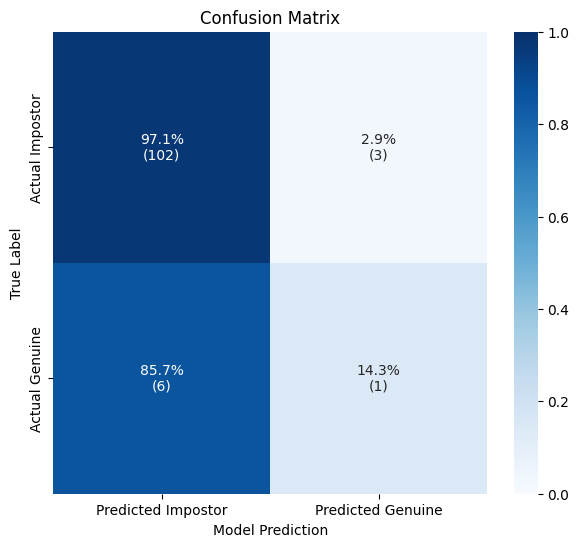

Interpretation:
  - Impostor Accuracy: 97.14% (102/105 blocked)
  - Genuine Accuracy:  14.29% (1/7 accepted)
  - False Acceptance Rate (FAR): 0.0286
  - False Rejection Rate (FRR):  0.8571


In [ ]:


def plot_weighted_biometric_confusion_matrix(y_true, y_scores, threshold=0.3):
    # 1. Convert scores to binary predictions
    y_pred = (y_scores > threshold).astype(int)

    # 2. Calculate Standard (Count) Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # 3. Calculate Normalized (Weighted) Matrix
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

    # 4. Create Custom Annotations (Percentage + Raw Count)
    # Example: "85.7% \n (6)"
    labels = [f"{val:.1%}\n({count})" for val, count in zip(cm_norm.flatten(), cm.flatten())]
    labels = np.asarray(labels).reshape(2, 2)

    # 5. Plotting
    plt.figure(figsize=(7, 6))

    sns.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues', cbar=True,
                xticklabels=['Predicted Impostor', 'Predicted Genuine'],
                yticklabels=['Actual Impostor', 'Actual Genuine'],
                vmin=0, vmax=1) 

    plt.title(f'Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Model Prediction')

    plt.show()

    print("Interpretation:")
    print(f"  - Impostor Accuracy: {tn/(tn+fp):.2%} ({tn}/{tn+fp} blocked)")
    print(f"  - Genuine Accuracy:  {tp/(tp+fn):.2%} ({tp}/{tp+fn} accepted)")
    print(f"  - False Acceptance Rate (FAR): {fp/(tn+fp):.4f}")
    print(f"  - False Rejection Rate (FRR):  {fn/(tp+fn):.4f}")

# --- EXECUTE ---
plot_weighted_biometric_confusion_matrix(y_test, y_scores, threshold=0.4)

Cleaned code

In [ ]:
def fix_model_for_shap(model):
    print("Patching model for SHAP compatibility...")
    count = 0
    for module in model.modules():
        if isinstance(module, nn.LeakyReLU):
            module.inplace = False
            count += 1
        elif isinstance(module, nn.ReLU):
            module.inplace = False
            count += 1
    print(f"Disabled inplace operations for {count} layers.")
    return model


mlp = fix_model_for_shap(mlp)

Patching model for SHAP compatibility...
Disabled inplace operations for 4 layers.


Generated 392 feature names.
Calculating SHAP values...


/tmp/ipython-input-4075936152.py:62: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


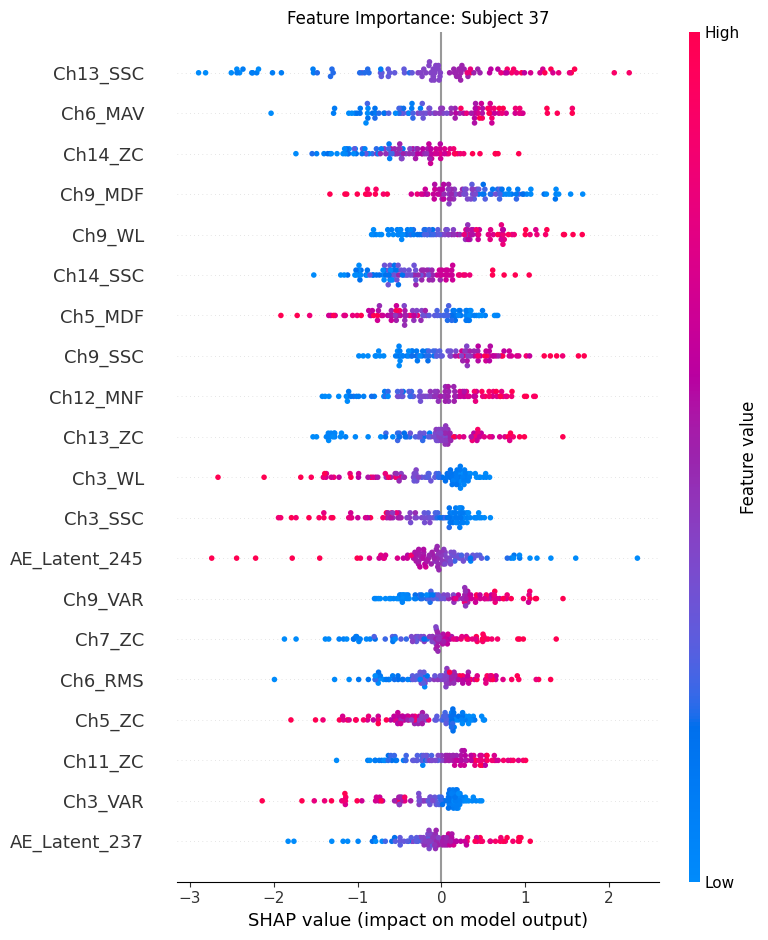

/tmp/ipython-input-4075936152.py:73: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


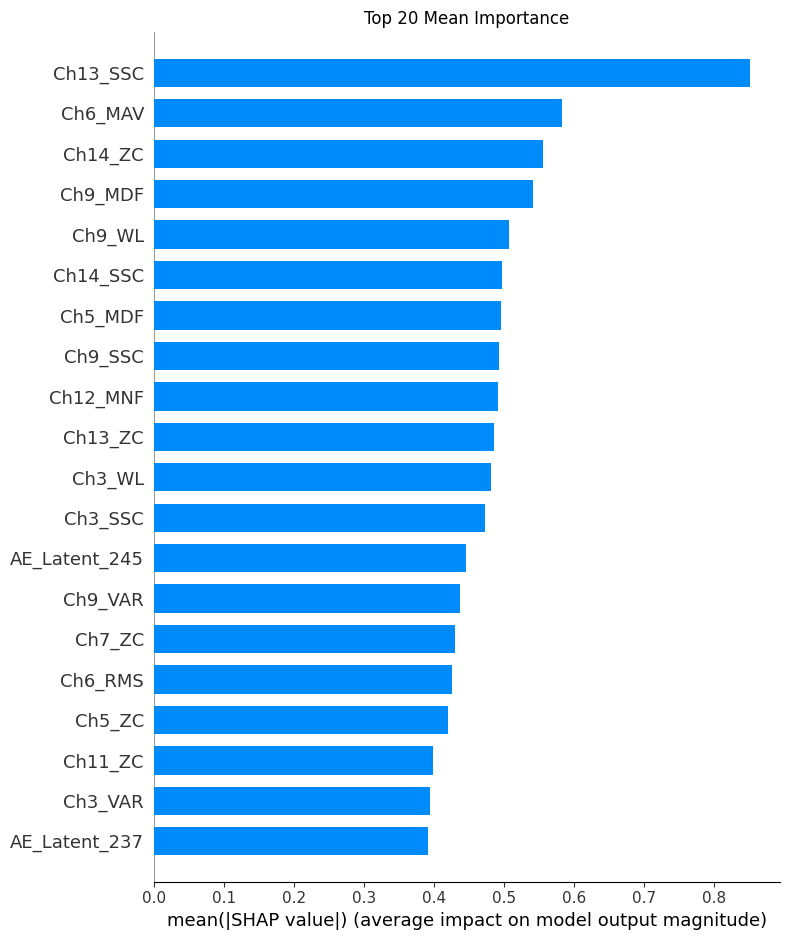

In [ ]:


# 1. GENERATE FEATURE NAMES
feat_types = ['MAV', 'RMS', 'VAR', 'WL', 'ZC', 'SSC', 'MNF', 'MDF']
num_channels = len(INCLUDE_CHANNELS)
discrete_names = []

for ch in range(num_channels):
    for ft in feat_types:
        discrete_names.append(f"Ch{ch+1}_{ft}")

# Calculate AE features
total_features = X_final.shape[1]
num_discrete = len(discrete_names)
num_ae = total_features - num_discrete
ae_names = [f"AE_Latent_{i}" for i in range(num_ae)]

feature_names = discrete_names + ae_names
print(f"Generated {len(feature_names)} feature names.")

# 2. PREPARE BACKGROUND DATA
background_indices = np.random.choice(len(X_ft_aug), size=200, replace=False)
background_data = torch.tensor(X_ft_aug[background_indices]).float().to(device)

# 3. INITIALIZE SHAP
mlp.eval()
explainer = shap.GradientExplainer(mlp, background_data)

# 4. CALCULATE SHAP VALUES
test_sample_indices = np.random.choice(len(X_test), size=100, replace=False)
test_samples_tensor = torch.tensor(X_test[test_sample_indices]).float().to(device)

print("Calculating SHAP values...")
shap_values = explainer.shap_values(test_samples_tensor)

# 5. PROCESSING SHAP OUTPUT
if isinstance(shap_values, list):
    if len(shap_values) == 1:
        vals_to_plot = shap_values[0]
    else:
        vals_to_plot = shap_values[1]
else:
    vals_to_plot = shap_values

# Squeeze if necessary (N, Features, 1) -> (N, Features)
if len(vals_to_plot.shape) == 3:
    vals_to_plot = vals_to_plot.squeeze()

# 6. VISUALIZE
plt.figure()
plt.title(f"Feature Importance: Subject {MAIN_SUBJECT}")
shap.summary_plot(
    vals_to_plot,
    X_test[test_sample_indices],
    feature_names=feature_names,
    max_display=20,
    show=True
)

# B. Bar Plot (Magnitude)
plt.figure()
plt.title(f"Top 20 Mean Importance")
shap.summary_plot(
    vals_to_plot,
    X_test[test_sample_indices],
    feature_names=feature_names,
    plot_type="bar",
    max_display=20,
    show=True
)